# General information
In Don't Overfit! II competition we have a binary classification task. 300 columns, 250 training samples and 79 times more samples in test data! We need to be able to build a model without overfitting.

In this kernel I'll write the following things:

* EDA on the features and trying to get some insights;
* Using permutation importance to select most impactful features;
* Comparing various models: bayer classification, linear models, tree based models;
* Trying various approaches to feature selection including taking top features from eli5 and shap;
* Hyperparameter optimization for models;
* Feature generation;
* Other things;

In [1]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
import json
import ast
import time
from sklearn import linear_model
import eli5
from eli5.sklearn import PermutationImportance
import warnings
warnings.filterwarnings("ignore")

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest,f_classif, mutual_info_classif, RFE
import statsmodels.api as sm

C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape

(250, 302)

# Data exploration

In [3]:
train.head()

,id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,-2.246,1.825,-0.912,-0.107,0.305,0.102,0.826,0.417,0.177,-0.673,-0.503,1.864,0.410,-1.927,0.102,-0.931,1.763,1.449,-1.097,-0.686,-0.250,-1.859,1.125,1.009,-2.296,0.385,-0.876,1.528,-0.144,-1.078,-0.403,0.005,1.405,-0.044,-0.458,0.579,2.929,0.833,0.761,0.737,0.669,0.717,-1.542,-1.847,-0.445,1.238,-0.840,-1.891,-1.531,-0.396,-0.927,2.072,0.946,-1.105,0.008,0.933,-1.410,-0.770,1.740,-1.504,-0.391,-1.551,-1.415,-0.974,0.796,-2.464,-1.424,1.230,0.219,0.130,-0.371,-0.930,1.851,1.292,-0.380,1.318,1.146,-0.399,2.227,0.447,0.870,1.420,-1.675,0.019,0.060,0.768,2.563,0.638,1.164,0.407,-1.556,-0.903,1.329,0.452,-0.704,2.218,-1.844,0.158,-1.649,-0.172,-1.167,-1.456,-0.778,0.098,-1.627,0.405,-0.082,-0.797,-0.303,0.710,-0.252,1.920,0.706,-0.915,0.267,-0.607,0.966,-0.337,-2.292,-1.366,-1.085,0.278,0.212,1.260,-1.276,-2.013,-1.101,0.797,0.661,1.232,-0.632,-0.805,1.236,-1.085,-0.067,-0.661,-0.745,1.306,-0.010,-0.475,-0.613,-0.841,-0.837,0.671,2.493,0.689,0.946,0.160,-0.607,-0.775,1.688,0.302,-1.156,-0.718,0.126,0.745,-0.287,-0.565,0.646,-0.119,-0.675,-0.479,-0.191,-0.454,1.314,0.740,0.999,1.242,-0.339,0.403,-1.243,1.365,0.030,-0.475,0.860,0.036,1.313,-0.219,1.078,1.880,-0.317,-0.443,1.876,-0.611,0.892,1.435,-0.226,0.311,0.139,-0.075,1.381,1.716,-2.017,-0.485,1.906,-0.119,0.609,-0.564,0.264,-0.604,-0.733,-2.352,-1.661,0.498,-0.841,0.907,-0.476,0.817,1.372,1.187,0.844,0.028,0.029,-0.808,0.253,1.005,1.413,-0.133,0.655,-0.921,0.231,-1.902,-0.005,-1.730,1.132,-0.194,0.039,1.489,-0.328,0.966,-0.057,-0.181,0.723,-0.313,-0.165,-0.803,0.074,-2.851,-1.021,-0.894,0.967,0.218,-0.692,-0.514,0.754,-1.892,0.203,2.174,-0.755,-1.053,-0.516,-1.109,-0.681,1.250,-0.565,-1.318,-0.923,0.075,-0.704,2.457,0.771,-0.460,0.569,-1.320,-1.516,-2.145,-1.120,0.156,0.820,-1.049,-1.125,0.484,0.617,1.253,1.248,0.504,-0.802,-0.896,-1.793,-0.284,-0.601,0.569,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,0.004,-0.291,2.907,1.085,2.144,1.540,0.584,1.133,1.098,-0.237,-0.498,0.283,-1.100,-0.417,1.382,-0.515,-1.519,0.619,-0.128,0.866,-0.540,1.238,-0.227,0.269,-0.390,-2.721,1.659,0.106,-0.121,1.719,0.411,-0.303,-0.307,0.380,0.503,-1.320,0.339,-1.102,-0.947,0.267,0.695,0.167,0.188,-1.082,-0.872,0.660,0.051,0.303,-0.553,-0.771,0.588,0.472,1.315,-0.467,-0.064,1.808,0.633,1.221,1.112,1.133,-0.543,-2.144,0.151,-0.813,1.966,-1.190,0.190,-0.473,0.002,1.195,-0.799,1.117,-0.759,-0.661,0.406,-0.846,-0.035,-1.634,-0.011,0.503,0.610,-1.822,-0.030,1.188,-0.006,-0.279,1.914,0.620,-1.495,1.787,-0.305,0.602,-1.208,0.893,0.379,1.396,0.581,-0.475,-0.056,-0.691,-0.783,-1.485,1.911,-2.400,-2.372,-0.178,1.550,-0.228,0.674,0.987,1.373,-0.373,0.629,0.229,-0.630,-0.175,0.548,0.074,-2.090,-0.625,-1.131,1.111,-0.100,0.574,-0.660,-1.113,0.802,-0.093,1.302,-0.395,0.745,-0.384,0.066,-0.756,0.495,-0.8

Text(0.5,1,'Distribution of stds of all columns')

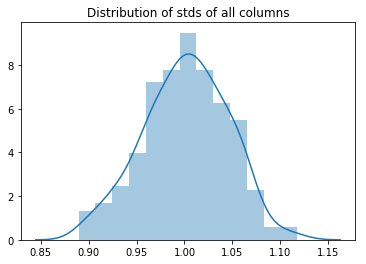

In [4]:
sns.distplot(pd.DataFrame(train[train.columns[2:]].std()))
plt.title('Distribution of stds of all columns')

Text(0.5,1,'Distribution of means of all columns')

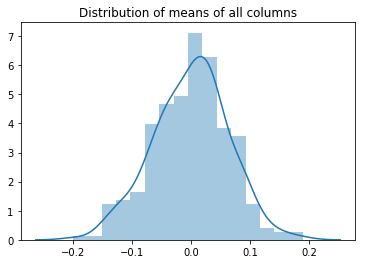

In [5]:
sns.distplot(pd.DataFrame(train[train.columns[2:]].mean()))
plt.title('Distribution of means of all columns')

In [6]:
# we have no missing values
train.isnull().any().any()

False

Distribution of first 28 columns


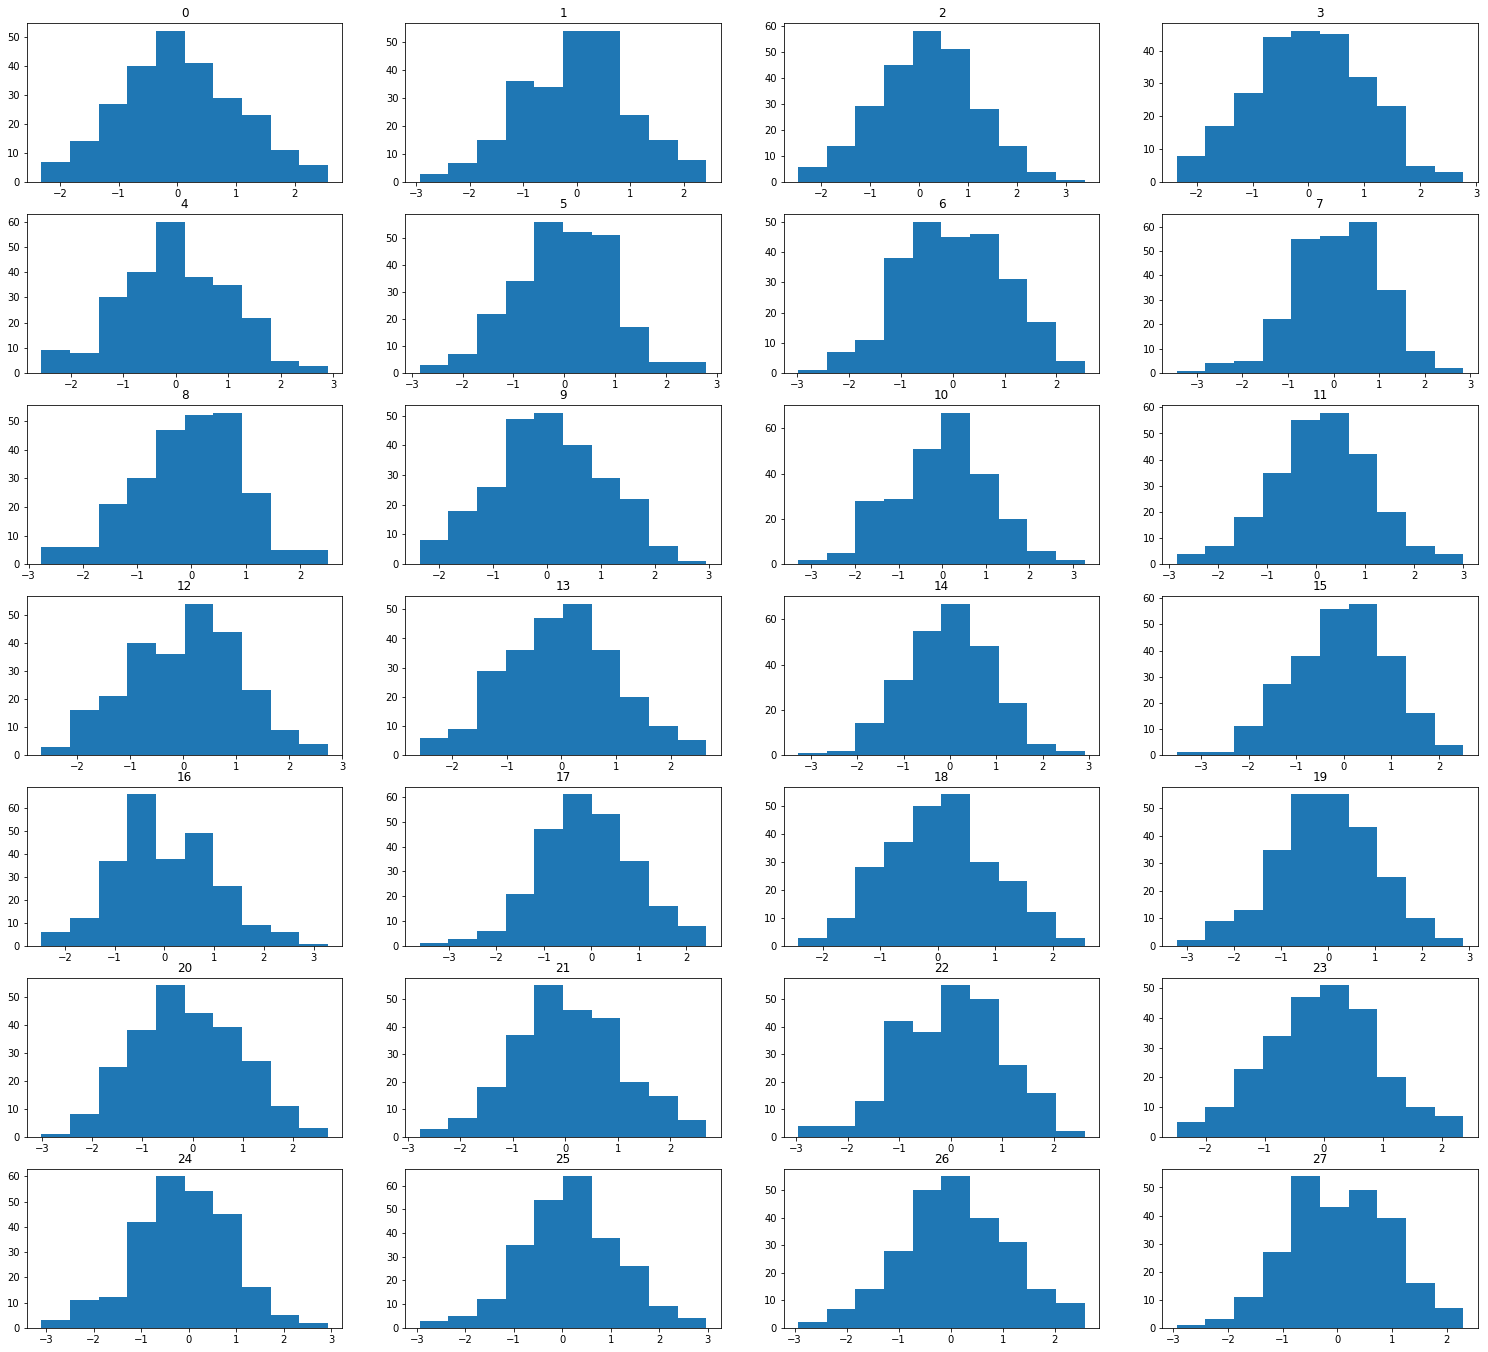

In [7]:
print('Distribution of first 28 columns')
plt.figure(figsize=(26,24))
for i, col in enumerate(list(train.columns)[2:30]):
    plt.subplot(7, 4, i + 1)
    plt.hist(train[col])
    plt.title(col)

In [8]:
train['target'].value_counts()

1.0    160
0.0     90
Name: target, dtype: int64

From this overview we can see the following things:

* target is binary and has some disbalance: 36% of samples belong to 0 class;
* values in columns are more or less similar;
* columns have std of 1 +/- 0.1 (min and max values are 0.889, 1.117 respectively);
* columns have mean of 0 +/- 0.15 (min and max values are -0.2, 0.1896 respectively);

Let's have a look at the correlations now!

In [9]:
corrs = train.corr().abs().unstack().sort_values(kind='quicksort').reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(10)

,level_0,level_1,0
90892,22,28,0.246062
90893,28,22,0.246062
90894,193,101,0.252825
90895,101,193,0.252825
90896,75,32,0.259315
90897,32,75,0.259315
90898,target,65,0.293846
90899,65,target,0.293846
90900,33,target,0.373608
90901,target,33,0.373608


We can see that correlations between features are lower that 0.3 and the most correlated feature with target has correlation of 0.37. So we have no highly correlated features which we could drop, on the other hand we could drop some columns with have little correlation with the target.

# Basic Modelling

In [10]:
x_train = train.drop(['id', 'target'], axis = 1)
y_train = train['target']
x_test = test.drop(['id'], axis = 1)
n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [53]:
def train_model(x, x_test, y, params, folds=folds, model_type='lgb', 
                plot_feature_importance=False, model=None):
    oof = np.zeros(len(x))
    prediction = np.zeros(len(x_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(x,y)):
        X_train, X_valid = x[train_index], x[valid_index]
        Y_train, Y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
                     eval_metric = 'auc', verbose=10000, early_stopping_rounds=200)
            y_pred_valid = model.predict_proba(X_valid, num_iteration=model.best_iteration_)[:,1]
            y_pred = model.predict_proba(x_test, num_iteration=model.best_iteration_)[:,1]
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=Y_train, feature_names = x_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=Y_valid, feature_names = x_train.columns)
            
            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist,
                             early_stopping_rounds=200, verbose_eval=500, params=params)
            
            y_pred_valid = model.predict_proba(xgb.DMatrix(X_valid, feature_names=x_train.columns),
                                        ntree_limit=model.best_ntree_limit)[:,1]
            y_pred = model.predict_proba(xgb.DMatrix(x_test, feature_names=x_train.columns), 
                                   ntree_limit=model.best_ntree_limit)[:,1]
            
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, Y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = roc_auc_score(Y_valid, y_pred_valid)
            print("Fold : {}, ras : {}".format(fold_n, score))
            print("")
            y_pred = model.predict_proba(x_test)[:, 1]
        
        if model_type == 'glm':
            model = sm.GLM(Y_train, X_train, family = sm.families.Binomial())
            model_results = model.fit()
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(Y_valid, y_pred_valid)
            print("Fold : {}, ras : {}".format(fold_n, score))
            print("")
            y_pred = model_results.predict(x_test)
        
            
        oof[valid_index] = y_pred_valid
        scores.append(roc_auc_score(Y_valid, y_pred_valid))
        prediction += y_pred
        
        if model_type == 'lgb':
            fold_importance = pd.DataFrame()
            fold_importance['feature'] = x_train.columns
            fold_importance['feature'] = fold_importance['feature'].astype(str)
            fold_importance['importance'] = model.feature_importances_
            fold_importance['fold'] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    prediction /= n_fold
    
    print('CV mean score: {}, std: {}'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        if plot_feature_importance:
            best_features = feature_importance[['feature', 'importance']].groupby('feature').mean().sort_values(
            by = 'importance', ascending=False).reset_index()[:30]
            plt.figure(figsize=(16,12))
            sns.barplot(best_features.feature, best_features.importance, order = best_features.feature)
            plt.title('LGB Features (avg over folds)')
            plt.plot()
            
            return oof, prediction, best_features
        return oof, prediction, scores
    else:
        return oof, prediction, scores

In [12]:
# a lot of people are using logreg currently, let's try
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1,
                                      solver='liblinear')
oof_lr, prediction_lr, scores_lr = train_model(x_train, x_test, y_train, 
                                               params=None, model_type='sklearn', model=model)

Fold : 0, ras : 0.638888888888889

Fold : 1, ras : 0.7326388888888888

Fold : 2, ras : 0.7256944444444444

Fold : 3, ras : 0.7881944444444444

Fold : 4, ras : 0.7881944444444444

Fold : 5, ras : 0.7013888888888888

Fold : 6, ras : 0.7569444444444444

Fold : 7, ras : 0.6909722222222222

Fold : 8, ras : 0.7881944444444444

Fold : 9, ras : 0.6145833333333334

CV mean score: 0.7225694444444444, std: 0.05858596913358168


In [13]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = prediction_lr
submission.to_csv('baseline.csv',index=False)

# ELI5 and permutation importance
ELI5 is a package with provides explanations for ML models. It can do this not only for linear models, but also for tree based like Random Forest or lightgbm.

In [14]:
eli5.show_weights(model, top=40)

Weight?,Feature
+0.646,x33
+0.417,x65
+0.178,x199
+0.098,x114
+0.069,x183
+0.020,x221
+0.012,x226
+0.011,<BIAS>
-0.004,x63
-0.011,x288


We can see that There are several features with highly positive weights and more features with negative weights. In fact there are only 32 features, which are important according to ELI5. Let's try using only them for the submission!

In [15]:
top_features = [i[1:] for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i]
x_train = train[top_features]
x_test = test[top_features]
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [16]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, _ = train_model(x_train, x_test, y_train, params=None, model_type='sklearn', model=model)

Fold : 0, ras : 0.7013888888888888

Fold : 1, ras : 0.8194444444444443

Fold : 2, ras : 0.7569444444444444

Fold : 3, ras : 0.7881944444444444

Fold : 4, ras : 0.7881944444444444

Fold : 5, ras : 0.7013888888888888

Fold : 6, ras : 0.8125

Fold : 7, ras : 0.7152777777777778

Fold : 8, ras : 0.7881944444444444

Fold : 9, ras : 0.6145833333333334

CV mean score: 0.748611111111111, std: 0.06115844126751108


Wow, we got improvement from 0.7226 to 0.7486 on CV! But this submission gives 0.845 on leaderboard. So it decreases score slightly. Let's try other things!

In [17]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = prediction_lr
submission.to_csv('baseline.csv',index=False)

# Permutation importance
There is also another way of using eli5 - we could have a look at permutation importance. It works in the following way:

* We fit a model;
* We randomly shuffle one column of validation data and calculate the score;
* If the score dropped significantly, it means that the feature is important;
You can read more about this approach here: https://www.kaggle.com/dansbecker/permutation-importance

In [18]:
perm = PermutationImportance(model, random_state=1).fit(x_train, y_train)
eli5.show_weights(perm, top=50)

Weight,Feature
0.1296 ± 0.0241,x0
0.0736 ± 0.0180,x1
0.0336 ± 0.0338,x31
0.0248 ± 0.0078,x25
0.0200 ± 0.0243,x2
0.0152 ± 0.0199,x27
0.0144 ± 0.0130,x26
0.0112 ± 0.0329,x30
0.0104 ± 0.0293,x28
0.0096 ± 0.0096,x24


In [19]:
top_features = [i[1:] for i in eli5.formatters.as_dataframe.explain_weights_df(perm).feature if 'BIAS' not in i]
x_train = train[top_features]
x_test = test[top_features]
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [20]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr1, prediction_lr1, _ = train_model(x_train, x_test, y_train, params=None, model_type='sklearn', model=model)

Fold : 0, ras : 0.6284722222222222

Fold : 1, ras : 0.4965277777777778

Fold : 2, ras : 0.2986111111111111

Fold : 3, ras : 0.6458333333333334

Fold : 4, ras : 0.5034722222222222

Fold : 5, ras : 0.6145833333333334

Fold : 6, ras : 0.4652777777777778

Fold : 7, ras : 0.5659722222222222

Fold : 8, ras : 0.4479166666666667

Fold : 9, ras : 0.670138888888889

CV mean score: 0.5336805555555556, std: 0.10833166398286467


Wow, if we select columns by permutation importance, CV score drops significantly. It seems it doesn't work well in out case.

# LGBM

In [21]:
x_train = train.drop(['id', 'target'], axis = 1)
y_train = train['target']
x_test = test.drop(['id'], axis = 1)
n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[16]	valid_0's auc: 0.747642	valid_1's auc: 0.791667
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[16]	valid_0's auc: 0.749143	valid_1's auc: 0.701389
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[108]	valid_0's auc: 0.810271	valid_1's auc: 0.847222
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[85]	valid_0's auc: 0.80457	valid_1's auc: 0.8125
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[358]	valid_0's auc: 0.896005	valid_1's auc: 0.826389
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[76]	valid_0's auc: 0.813443	valid_1's auc: 0.75
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[

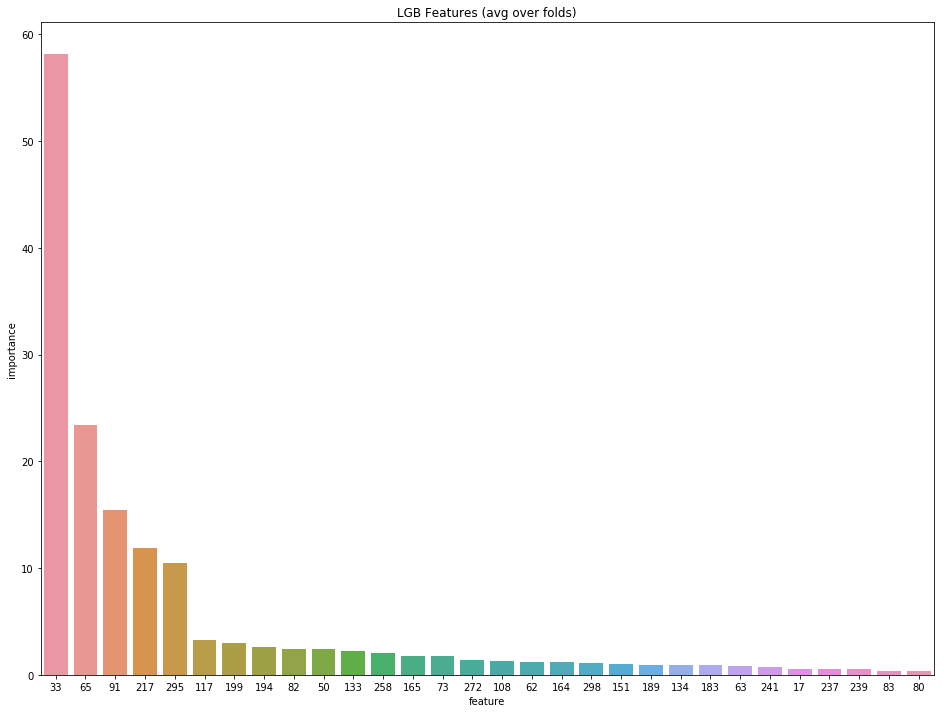

In [54]:
params = {
    'num_leaves': 54,
         'min_data_in_leaf': 79,
         'objective': 'binary',
         'max_depth': -1,
         'learning_rate': 0.01,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'bagging_fraction': 0.8126672064208567,
         'bagging_seed': 11,
         'verbosity': -1,
         'reg_alpha': 0.1302650970728192,
         'reg_lambda': 0.3603427518866501}
oof_lgb, prediction_lgb, scores = train_model(x_train_scaled, x_test_scaled, y_train, params=params, plot_feature_importance=True)

In [175]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = prediction_lgb
submission.to_csv('baseline_lgb.csv',index=False)

# Logistic Regression

In [57]:
lr = linear_model.LogisticRegression(solver='liblinear', max_iter = 1000)

param_grid = {'class_weight' : ['balanced', None],
                 'penalty': ['l2'],
                 'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                 'solver': ['newton-cg', 'sag', 'lbfgs']}

grid_search = GridSearchCV(lr, param_grid = param_grid, cv=folds, scoring='roc_auc')
grid_search.fit(x_train_scaled, y_train)
print("Best score : ", grid_search.best_score_)
print('Best parameters : ', grid_search.best_params_)

Best score :  0.7638888888888888
Best parameters :  {'C': 100.0, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'sag'}


In [59]:
lr = linear_model.LogisticRegression(solver='liblinear', max_iter = 1000)

param_grid = {'class_weight' : ['balanced', None],
                 'penalty': ['l2', 'l1'],
                 'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

grid_search = GridSearchCV(lr, param_grid = param_grid, cv=folds, scoring='roc_auc')
grid_search.fit(x_train_scaled, y_train)
print("Best score : ", grid_search.best_score_)
print('Best parameters : ', grid_search.best_params_)

Best score :  0.8027777777777779
Best parameters :  {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'}


In [60]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, scores = train_model(x_train_scaled, x_test_scaled, y_train, params=None, model_type='sklearn', model=model)

Fold : 0, ras : 0.638888888888889

Fold : 1, ras : 0.7326388888888888

Fold : 2, ras : 0.7256944444444444

Fold : 3, ras : 0.7881944444444444

Fold : 4, ras : 0.7881944444444444

Fold : 5, ras : 0.7013888888888888

Fold : 6, ras : 0.7569444444444444

Fold : 7, ras : 0.6909722222222222

Fold : 8, ras : 0.7881944444444444

Fold : 9, ras : 0.6145833333333334

CV mean score: 0.7225694444444444, std: 0.05858596913358168


So, parameters for logreg are optimal, let's try other models

In [63]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
oof_gnb, prediction_gnb, scores_gnb = train_model(x_train_scaled, 
                                                  x_test_scaled, 
                                                  y_train, 
                                                  params=None,
                                                  model_type='sklearn', 
                                                  model=gnb)

Fold : 0, ras : 0.4305555555555556

Fold : 1, ras : 0.8333333333333334

Fold : 2, ras : 0.6354166666666667

Fold : 3, ras : 0.7152777777777778

Fold : 4, ras : 0.5729166666666667

Fold : 5, ras : 0.8576388888888888

Fold : 6, ras : 0.7708333333333335

Fold : 7, ras : 0.6666666666666667

Fold : 8, ras : 0.6597222222222222

Fold : 9, ras : 0.517361111111111

CV mean score: 0.6659722222222222, std: 0.12857353362719218


In [66]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()

param_grid = {'n_estimators' : [5, 10, 20, 50, 100],
                 'learning_rate': [0.001, 0.01, 0.1, 1.0, 10.0]}

grid_search = GridSearchCV(abc, param_grid = param_grid, cv=folds, 
                          scoring='roc_auc')
grid_search.fit(x_train_scaled, y_train)
print("Best score : ", grid_search.best_score_)
print('Best parameters : ', grid_search.best_params_)

Best score :  0.7159722222222222
Best parameters :  {'learning_rate': 1.0, 'n_estimators': 50}


In [67]:
abc = AdaBoostClassifier(**grid_search.best_params_)
oof_abc, prediction_abc, scores_abc = train_model(x_train_scaled, 
                                                  x_test_scaled, 
                                                  y_train, 
                                                  params=None, 
                                                  model_type='sklearn',
                                                  model=abc)

Fold : 0, ras : 0.6041666666666667

Fold : 1, ras : 0.5972222222222222

Fold : 2, ras : 0.6770833333333335

Fold : 3, ras : 0.7708333333333335

Fold : 4, ras : 0.517361111111111

Fold : 5, ras : 0.6041666666666667

Fold : 6, ras : 0.7708333333333335

Fold : 7, ras : 0.5972222222222222

Fold : 8, ras : 0.7465277777777777

Fold : 9, ras : 0.6597222222222222

CV mean score: 0.654513888888889, std: 0.08155288393482124


In [69]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()

parameter_grid = {'n_estimators': [10,50,100,1000],
                 'max_depth': [None, 3, 5, 15]}

grid_search = GridSearchCV(etc, param_grid=parameter_grid, cv=folds,
                          scoring='roc_auc', n_jobs=-1)
grid_search.fit(x_train_scaled, y_train)
print('Best score : ', grid_search.best_score_)
print('Best parameters : ', grid_search.best_params_)
etc = ExtraTreeClassifier(**grid_search.best_params_)
oof_etc, prediction_etc, scores_etc = train_model(x_train_scaled,
                                                 x_test_scaled,
                                                 y_train, params=None,
                                                 model_type='sklearn',
                                                 model=etc)

Best score :  0.7708333333333334
Best parameters :  {'max_depth': 3, 'n_estimators': 1000}


NameError: name 'ExtraTreeClassifier' is not defined